# **Machine Learning (ML) Methods**

**Unsupervised Learning**

**KMeans clustering**

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import ast

In [39]:
# Load your data
df = pd.read_csv("lightcast_job_postings.csv")

C:\Users\prabu\AppData\Local\Temp\ipykernel_17132\4181052193.py:2: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lightcast_job_postings.csv")


In [40]:
# Select the relevant columns
cols_to_clean = ['NAICS_2022_6_NAME']

# Fill missing values with 'Unknown' and strip extra spaces/lowercase
for col in cols_to_clean:
    df[col] = df[col].fillna('Unknown').astype(str).str.strip().str.lower()

# Optionally check unique counts
for col in cols_to_clean:
    print(f"{col}: {df[col].nunique()} unique values")

NAICS_2022_6_NAME: 815 unique values


**Clean and Preparing Reference Label Columns**

In [41]:
# Combine cleaned columns into a single string
df['combined_text'] = df['NAICS_2022_6_NAME']


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to combined column
tfidf = TfidfVectorizer(max_features=815)  # adjust max_features as needed
X_tfidf = tfidf.fit_transform(df['combined_text']).toarray()

# Convert to DataFrame for merging
df_tfidf = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())

In [43]:
# Create salary column
df['SALARY_AVG'] = df[['SALARY_TO', 'SALARY_FROM']].mean(axis=1)
df['SALARY_AVG'] = df['SALARY_AVG'].fillna(df['SALARY'])

# Fill remaining salary NaNs with 0
df['SALARY_AVG'] = df['SALARY_AVG'].fillna(0)

# Combine TF-IDF + salary into clustering matrix
from sklearn.preprocessing import StandardScaler

X_cluster = pd.concat([df_tfidf, df[['SALARY_AVG']].reset_index(drop=True)], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=218)
df['cluster'] = kmeans.fit_predict(X_scaled)


**Silhouette to Choose Optimal K**

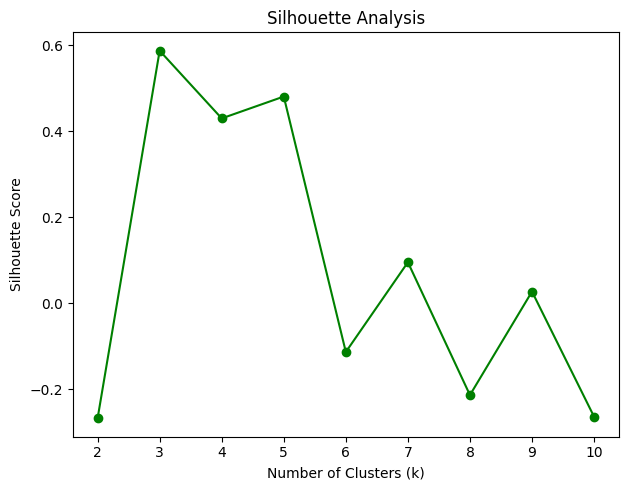

In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different k values
sse = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, n_init=3, random_state=42)
    labels = km.fit_predict(X_scaled)

    sse.append(km.inertia_)

    #  Use built-in sample_size to avoid slicing manually
    score = silhouette_score(X_scaled, labels, sample_size=10000, random_state=218)
    silhouette_scores.append(score)

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))


# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


**Fit KMeans and Label the Data with Clusters**

In [46]:
from sklearn.cluster import KMeans

# Re-fit using optimal k = 3
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
df['cluster'] = kmeans_final.fit_predict(X_scaled)


**Visualize: Job Types by Salary (e.g., Boxplot)**

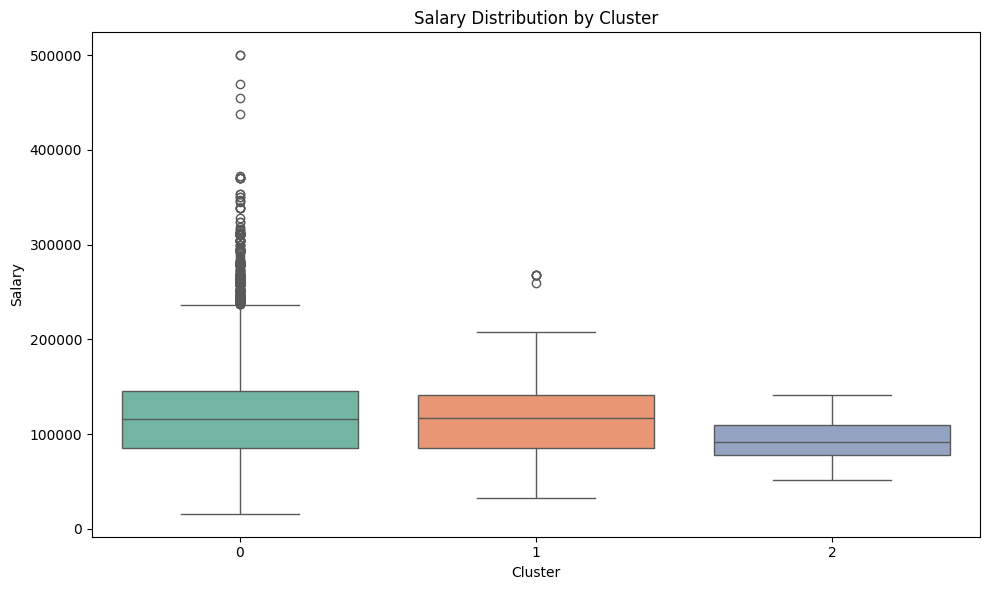

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='SALARY', hue='cluster', palette='Set2', legend=False)
plt.title("Salary Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()


**Visualize: Industry vs. Cluster Heatmap**

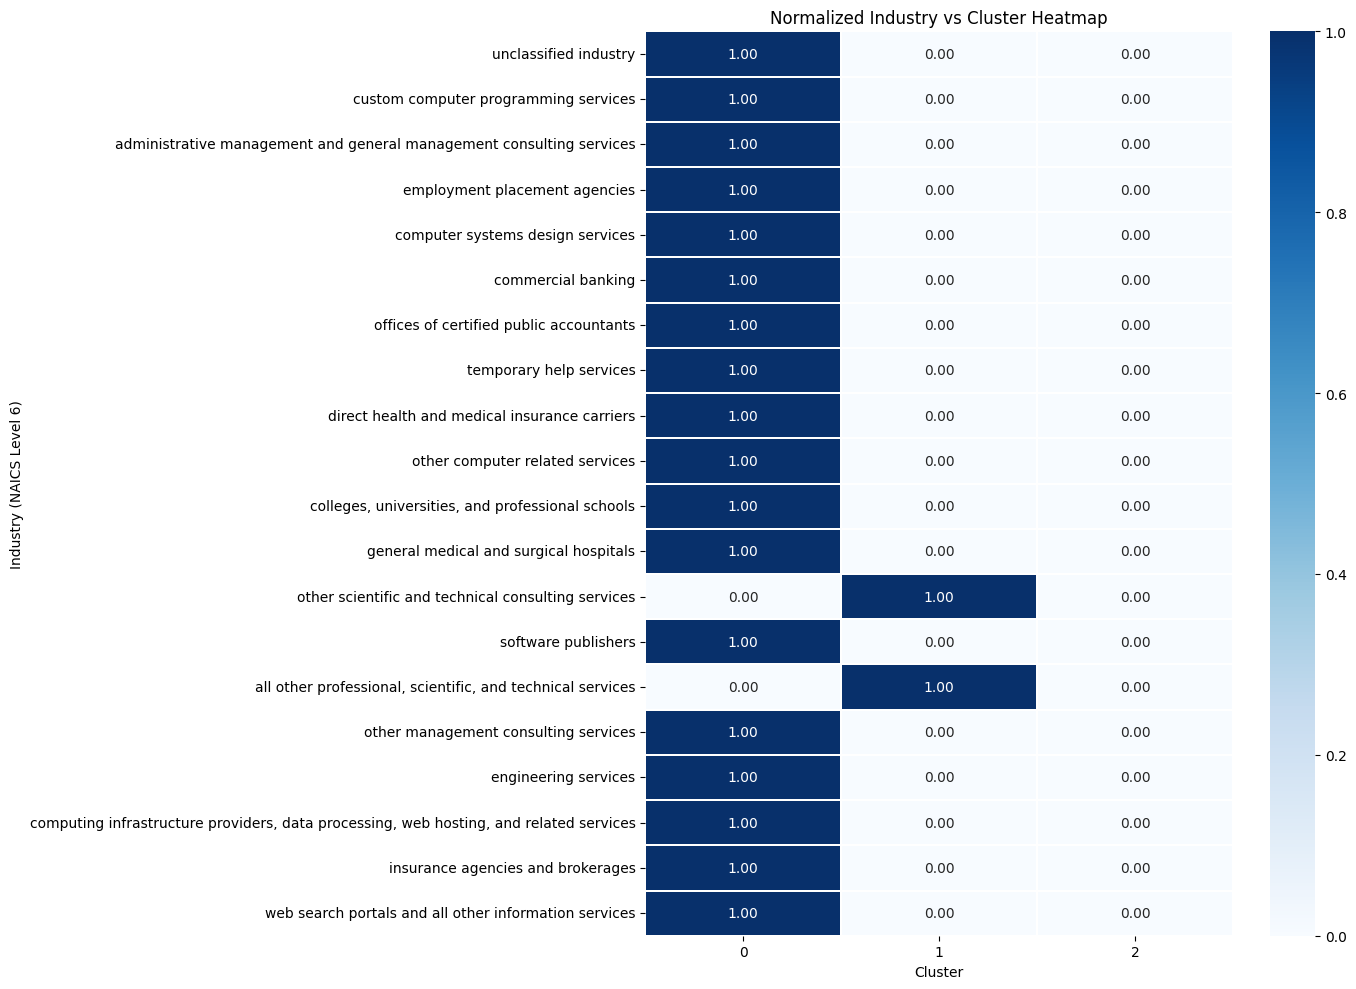

In [48]:
# Create a normalized crosstab (row-wise proportions)
cluster_industry = pd.crosstab(df['NAICS_2022_6_NAME'], df['cluster'], normalize='index')

# Optional: Filter top N industries with most entries (optional)
top_industries = df['NAICS_2022_6_NAME'].value_counts().head(20).index
cluster_industry = cluster_industry.loc[top_industries]

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_industry, cmap='Blues', annot=True, fmt=".2f", linewidths=0.3)
plt.title("Normalized Industry vs Cluster Heatmap")
plt.xlabel("Cluster")
plt.ylabel("Industry (NAICS Level 6)")
plt.tight_layout()
plt.show()


**Cluster Distribution Across Top Industries**

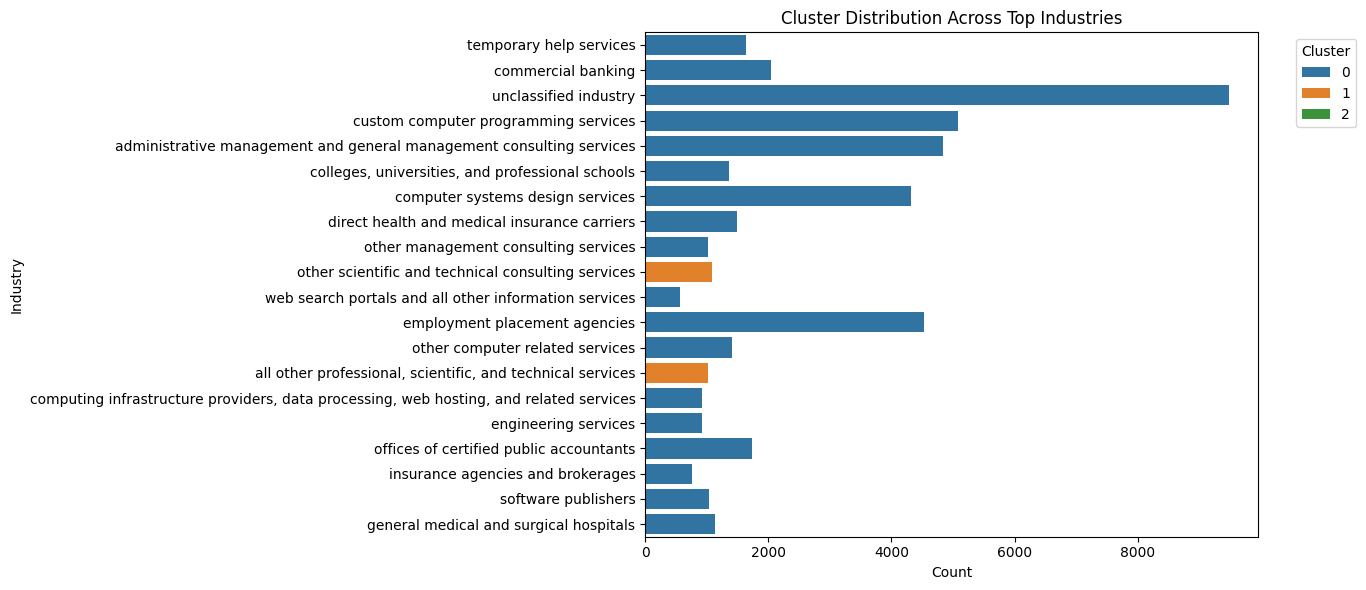

In [49]:
# Ensure 'cluster' is treated as a category with all possible clusters
df['cluster'] = pd.Categorical(df['cluster'])

# Optional: define all expected cluster labels explicitly (0, 1, 2, etc.)
df['cluster'] = df['cluster'].cat.set_categories([0, 1, 2])  # <-- include all known clusters

# Get top industries by count
top_industries = df['NAICS_2022_6_NAME'].value_counts().head(20).index
top_df = df[df['NAICS_2022_6_NAME'].isin(top_industries)]

# Plot
plt.figure(figsize=(14, 6))
sns.countplot(data=top_df, y='NAICS_2022_6_NAME', hue='cluster', palette='tab10')
plt.title("Cluster Distribution Across Top Industries")
plt.xlabel("Count")
plt.ylabel("Industry")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**TF-IDF Based Clustering (Bonus)**

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Use job descriptions or skills (cleaned text column)
corpus = df['BODY'].fillna('')  # or use 'TITLE_RAW' or 'SKILLS_NAME'

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(corpus)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
tfidf_labels = kmeans.fit_predict(X_tfidf)

# Add cluster labels
df['TFIDF_Cluster'] = tfidf_labels

**TF-IDF Vectorization**

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use 'BODY' as the text source (fallback to 'TITLE_RAW' if BODY is too sparse)
df['BODY'] = df['BODY'].fillna('')

vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=5
)

X_tfidf = vectorizer.fit_transform(df['BODY'])

**KMeans Clustering on TF-IDF**

In [52]:
from sklearn.cluster import KMeans

k_tfidf = 3  # or test different values like before
kmeans_tfidf = KMeans(n_clusters=k_tfidf, random_state=42)
df['TFIDF_Cluster'] = kmeans_tfidf.fit_predict(X_tfidf)

**Top Terms per Cluster**

In [53]:
import numpy as np

# Get feature names
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]

# Print top terms for each cluster
for i in range(k_tfidf):
    top_terms = [terms[ind] for ind in order_centroids[i, :12]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")

Cluster 0 top terms: oracle, experience, business, job, work, management, enterprise, architecture, skills, cloud, solutions, technical
Cluster 1 top terms: data, experience, business, work, analytics, job, analyst, analysis, skills, data analyst, management, reporting
Cluster 2 top terms: sap, experience, business, job, consultant, hana, experience sap, functional, accenture, sd, id, work


**Visualize TF-IDF Clusters**

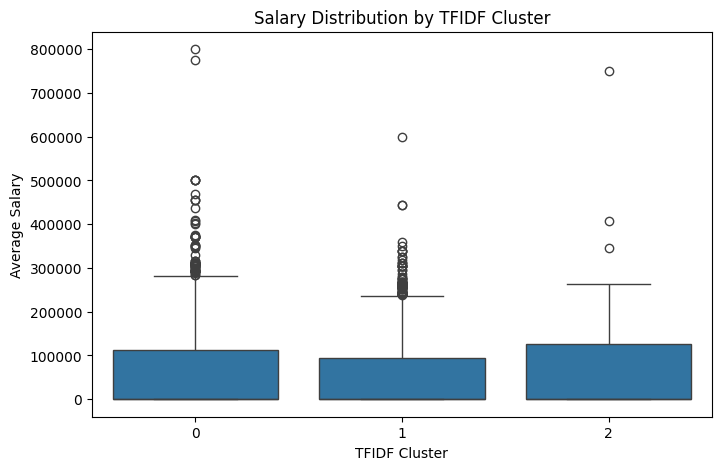

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot salary by TFIDF cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='TFIDF_Cluster', y='SALARY_AVG')
plt.title('Salary Distribution by TFIDF Cluster')
plt.xlabel('TFIDF Cluster')
plt.ylabel('Average Salary')
plt.show()

**Industry Distribution in TF-IDF Clusters**

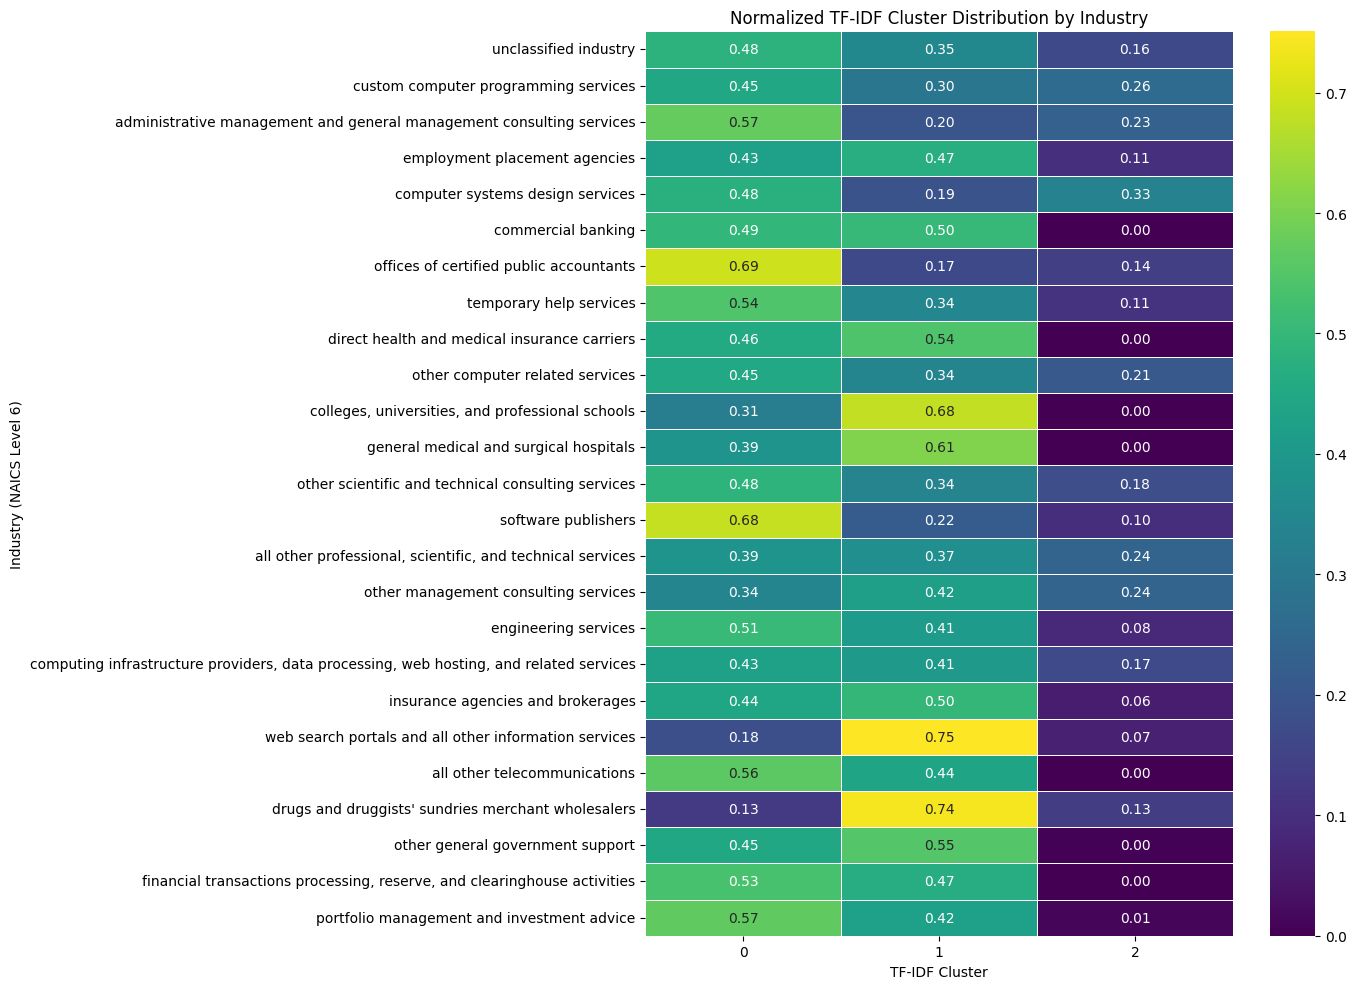

In [55]:
# Step 1: Compute normalized cluster distribution per industry
industry_cluster = (
    df.groupby(['NAICS_2022_6_NAME', 'TFIDF_Cluster'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Normalize by industry (row-wise proportions)
industry_cluster_normalized = industry_cluster.div(industry_cluster.sum(axis=1), axis=0)

# Step 3: Filter top industries by total count (optional but recommended for clarity)
top_industries = df['NAICS_2022_6_NAME'].value_counts().head(25).index
filtered = industry_cluster_normalized.loc[top_industries]

# Step 4: Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(filtered, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Normalized TF-IDF Cluster Distribution by Industry")
plt.xlabel("TF-IDF Cluster")
plt.ylabel("Industry (NAICS Level 6)")
plt.tight_layout()
plt.show()